# Data distribution analysis for *Currais et al.*

Tong Shu Li

We perform some exploratory analysis of the data in [PMID:26564964](http://www.ncbi.nlm.nih.gov/pubmed/26564964) for analysis.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys

In [2]:
sys.path.append("../..")

In [3]:
from src.plots import plot_multi_density

In [4]:
%matplotlib inline

---

## Read the filtered gene counts

In [5]:
data = pd.read_csv("filtered_expression.tsv", sep = '\t')

In [6]:
data.shape

(152520, 8)

In [7]:
data.head()

,gene_id,gene_count,sample_name,sample,months_old,drug_given,replicate,log_count
0,Xkr4,92,old_J147.1,8,10,j147,1,4.521789
1,Sox17,80,old_J147.1,8,10,j147,1,4.382027
2,Mrpl15,421,old_J147.1,8,10,j147,1,6.042633
3,Lypla1,309,old_J147.1,8,10,j147,1,5.733341
4,Tcea1,224,old_J147.1,8,10,j147,1,5.411646


## Number of unique genes

In [8]:
data["gene_id"].nunique()

15252

## Log count distribution for all samples

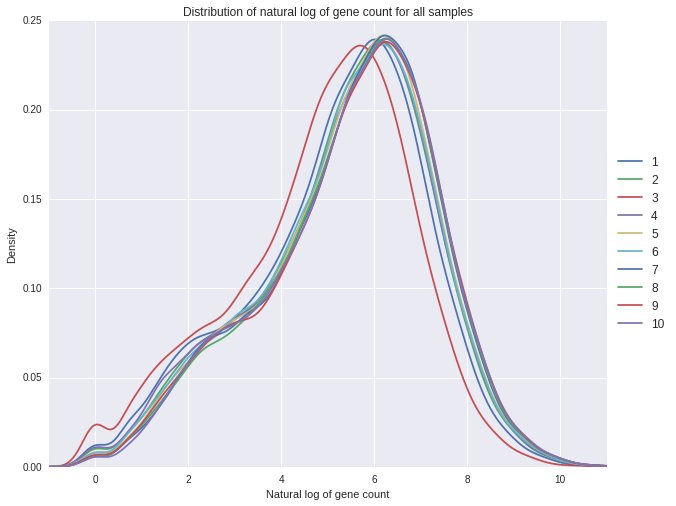

In [9]:
fig = plot_multi_density(
    data, "gene_id", "sample", "log_count",
    rc = {"figure.figsize": (10, 8)}
)

fig.set_xlim((-1, 11))
fig.legend(loc = "center left", bbox_to_anchor = (1, 0.5), prop = {"size": 12})
fig.set_title("Distribution of natural log of gene count for all samples")
fig.set_xlabel("Natural log of gene count")

Sample 3 is obviously shifted to the left compared to the other samples. Sample 1 is also shifted to the left, but less so than sample 3.

## Replot without samples 1 and 3

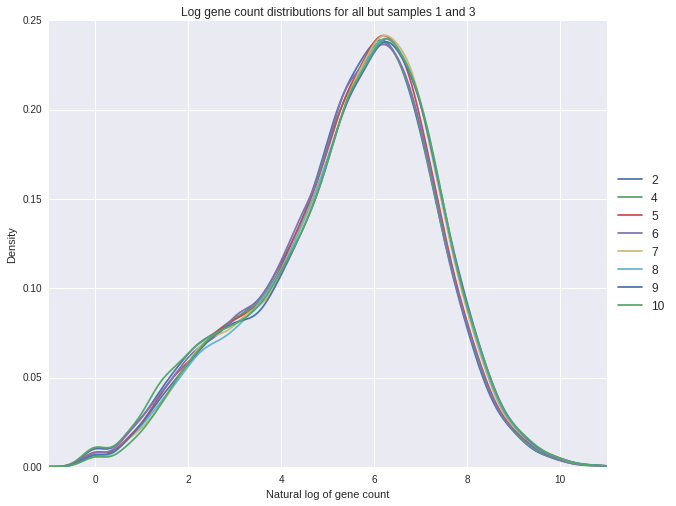

In [10]:
fig = plot_multi_density(
    data.query("sample not in(1, 3)"), "gene_id", "sample", "log_count",
    rc = {"figure.figsize": (10, 8)}
)

fig.set_xlim((-1, 11))
fig.legend(loc = "center left", bbox_to_anchor = (1, 0.5), prop = {"size": 12})
fig.set_title("Log gene count distributions for all but samples 1 and 3")
fig.set_xlabel("Natural log of gene count")

Looks like samples 1 and 3 are shifted to the left in terms of log(gene count). For simplicity, we will remove sample 3, but keep sample 1 since it was shifted less.

---

## Distribution of young mice

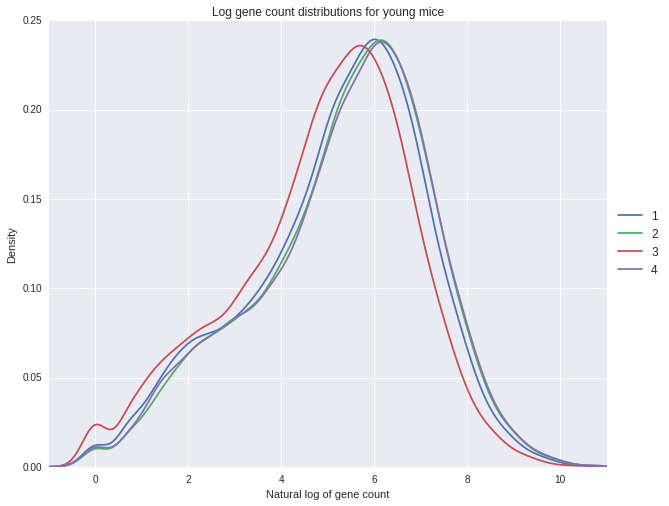

In [11]:
fig = plot_multi_density(
    data.query("sample <= 4"), "gene_id", "sample", "log_count",
    rc = {"figure.figsize": (10, 8)}
)

fig.set_xlim((-1, 11))
fig.legend(loc = "center left", bbox_to_anchor = (1, 0.5), prop = {"size": 12})
fig.set_title("Log gene count distributions for young mice")
fig.set_xlabel("Natural log of gene count")

## Distribution of old untreated mice

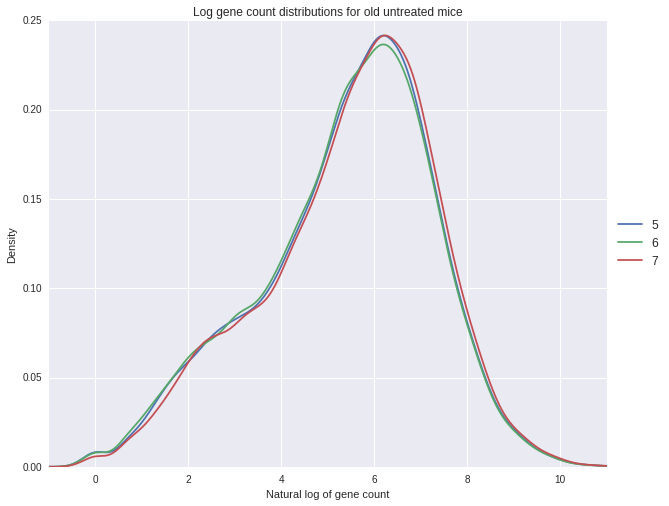

In [12]:
fig = plot_multi_density(
    data.query("months_old == 10 & drug_given == 'vehicle'"),
    "gene_id", "sample", "log_count",
    rc = {"figure.figsize": (10, 8)}
)

fig.set_xlim((-1, 11))
fig.legend(loc = "center left", bbox_to_anchor = (1, 0.5), prop = {"size": 12})
fig.set_title("Log gene count distributions for old untreated mice")
fig.set_xlabel("Natural log of gene count")

## Distribution for old mice treated with J147

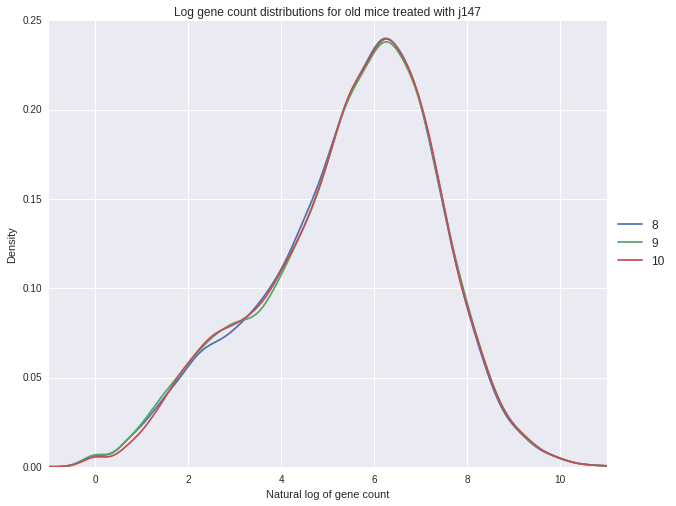

In [13]:
fig = plot_multi_density(
    data.query("months_old == 10 & drug_given == 'j147'"),
    "gene_id", "sample", "log_count",
    rc = {"figure.figsize": (10, 8)}
)

fig.set_xlim((-1, 11))
fig.legend(loc = "center left", bbox_to_anchor = (1, 0.5), prop = {"size": 12})
fig.set_title("Log gene count distributions for old mice treated with j147")
fig.set_xlabel("Natural log of gene count")

The distribution for the old treated mice looks very nice, which is promising.

## Calculating drift

We will:

1. Drop sample 3 due to the lower expression distribution.
2. Examine which of the three young samples to choose as the young reference.
3. Pick a sample to be the young reference.
4. Average the counts together.
5. Calculate drift.

## Drop sample 3

In [14]:
clean = data.query("sample != 3")

In [15]:
clean.shape

(137268, 8)

In [16]:
clean.head()

,gene_id,gene_count,sample_name,sample,months_old,drug_given,replicate,log_count
0,Xkr4,92,old_J147.1,8,10,j147,1,4.521789
1,Sox17,80,old_J147.1,8,10,j147,1,4.382027
2,Mrpl15,421,old_J147.1,8,10,j147,1,6.042633
3,Lypla1,309,old_J147.1,8,10,j147,1,5.733341
4,Tcea1,224,old_J147.1,8,10,j147,1,5.411646


## Picking a young reference

We will try using all three samples as a young reference.

In [17]:
temp = []
for sample in [1, 2, 4]:
    res = clean.query("sample == {}".format(sample))[["gene_id", "log_count"]]
    res = res.rename(columns = {"log_count": "ref_log_count"})
    res["ref_sample"] = sample
    
    temp.append(res)
    
ref = pd.concat(temp).reset_index(drop = True)

In [18]:
ref.head()

,gene_id,ref_log_count,ref_sample
0,Xkr4,4.727388,1
1,Sox17,4.174387,1
2,Mrpl15,5.686975,1
3,Lypla1,5.484797,1
4,Tcea1,5.068904,1


## Merge reference expression

In [19]:
final = pd.merge(clean, ref, how = "left", on = "gene_id")

In [20]:
final.shape

(411804, 10)

In [21]:
final.head()

,gene_id,gene_count,sample_name,sample,months_old,drug_given,replicate,log_count,ref_log_count,ref_sample
0,Xkr4,92,old_J147.1,8,10,j147,1,4.521789,4.727388,1
1,Xkr4,92,old_J147.1,8,10,j147,1,4.521789,4.990433,2
2,Xkr4,92,old_J147.1,8,10,j147,1,4.521789,4.532599,4
3,Sox17,80,old_J147.1,8,10,j147,1,4.382027,4.174387,1
4,Sox17,80,old_J147.1,8,10,j147,1,4.382027,4.442651,2


## Calculate drift

In [22]:
final["drift"] = final["log_count"] - final["ref_log_count"]

In [23]:
final.head()

,gene_id,gene_count,sample_name,sample,months_old,drug_given,replicate,log_count,ref_log_count,ref_sample,drift
0,Xkr4,92,old_J147.1,8,10,j147,1,4.521789,4.727388,1,-0.205599
1,Xkr4,92,old_J147.1,8,10,j147,1,4.521789,4.990433,2,-0.468644
2,Xkr4,92,old_J147.1,8,10,j147,1,4.521789,4.532599,4,-0.010811
3,Sox17,80,old_J147.1,8,10,j147,1,4.382027,4.174387,1,0.207639
4,Sox17,80,old_J147.1,8,10,j147,1,4.382027,4.442651,2,-0.060625


In [24]:
final.shape

(411804, 11)

## Examine drift distribution of samples with different young references

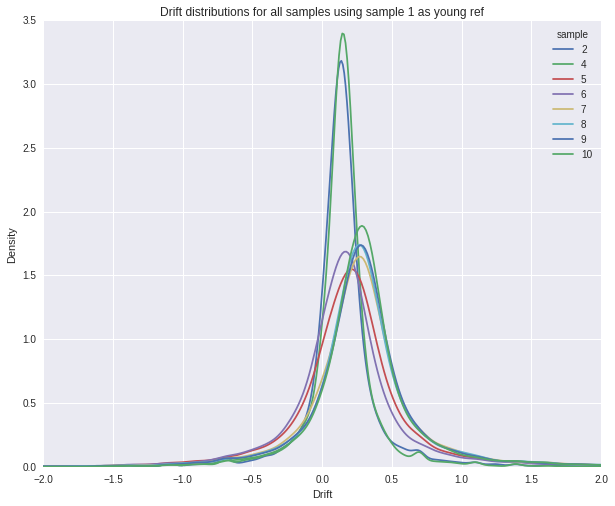

In [25]:
ref_sample = 1

fig = plot_multi_density(
    final.query("sample != {} & ref_sample == {}".format(ref_sample, ref_sample)),
    "gene_id", "sample", "drift",
    rc = {"figure.figsize": (10, 8)}
)

fig.set_xlim((-2, 2))
fig.set_title("Drift distributions for all samples using sample {} as young ref".format(ref_sample))
fig.set_xlabel("Drift")

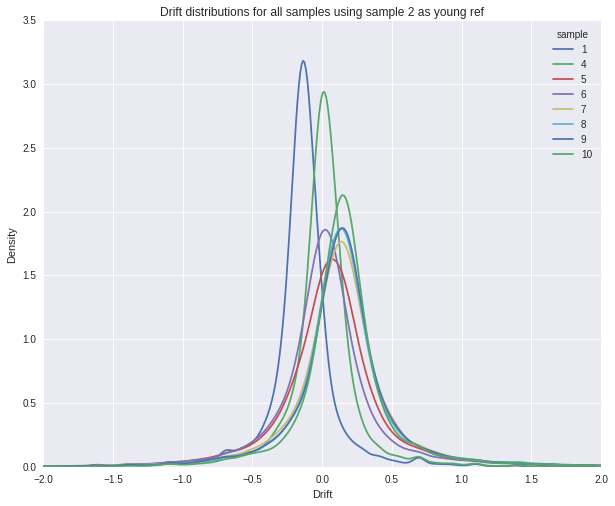

In [26]:
ref_sample = 2

fig = plot_multi_density(
    final.query("sample != {} & ref_sample == {}".format(ref_sample, ref_sample)),
    "gene_id", "sample", "drift",
    rc = {"figure.figsize": (10, 8)}
)

fig.set_xlim((-2, 2))
fig.set_title("Drift distributions for all samples using sample {} as young ref".format(ref_sample))
fig.set_xlabel("Drift")

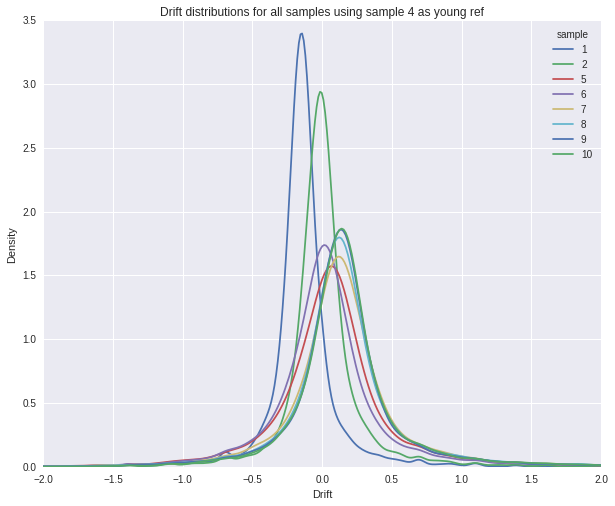

In [27]:
ref_sample = 4

fig = plot_multi_density(
    final.query("sample != {} & ref_sample == {}".format(ref_sample, ref_sample)),
    "gene_id", "sample", "drift",
    rc = {"figure.figsize": (10, 8)}
)

fig.set_xlim((-2, 2))
fig.set_title("Drift distributions for all samples using sample {} as young ref".format(ref_sample))
fig.set_xlabel("Drift")

The drift distributions are all over the place. This is probably not a very good sign. Looks like there is discrepancy with the two other samples used as a young reference. Sample 1 and sample 4 are quite far apart.

Hopefully it will be ok to take the mean for biological replicates.

## Pick sample 1 as the young reference

It seems that sample 1 gives drift distributions which are closest to one another. We will use it as the young reference.

## Average the counts

In [28]:
samples = clean.query("sample != 1")

avg = samples.groupby(["months_old", "drug_given", "gene_id"], as_index = False).agg(np.mean)
avg = avg.drop(["sample", "replicate"], axis = 1)

avg["log_count"] = np.log(avg["gene_count"])

In [29]:
avg.shape

(45756, 5)

In [30]:
avg.head()

,months_old,drug_given,gene_id,gene_count,log_count
0,3,vehicle,0610007P14Rik,342.5,5.836272
1,3,vehicle,0610009B22Rik,154.0,5.036953
2,3,vehicle,0610009L18Rik,23.5,3.157000
3,3,vehicle,0610009O20Rik,551.0,6.311735
4,3,vehicle,0610010F05Rik,694.0,6.542472


In [31]:
avg["gene_id"].nunique()

15252

## Merge in reference

In [32]:
res = pd.merge(avg, ref.query("ref_sample == 1"), on = "gene_id", how = "left")
res["drift"] = res["log_count"] - res["ref_log_count"]

In [33]:
res.shape

(45756, 8)

In [34]:
res.head()

,months_old,drug_given,gene_id,gene_count,log_count,ref_log_count,ref_sample,drift
0,3,vehicle,0610007P14Rik,342.5,5.836272,5.720312,1,0.115960
1,3,vehicle,0610009B22Rik,154.0,5.036953,4.836282,1,0.200671
2,3,vehicle,0610009L18Rik,23.5,3.157000,2.944439,1,0.212561
3,3,vehicle,0610009O20Rik,551.0,6.311735,6.214608,1,0.097127
4,3,vehicle,0610010F05Rik,694.0,6.542472,6.545350,1,-0.002878


In [35]:
res.groupby(["months_old", "drug_given"]).size()

months_old  drug_given
3           vehicle       15252
10          j147          15252
            vehicle       15252
dtype: int64

In [36]:
temp = pd.DataFrame(
    {
        "months_old": [3, 10, 10],
        "drug_given": ["vehicle", "vehicle", "j147"],
        "sample_name": ["young", "old_control", "old_j147"]
    }
)

In [37]:
temp

,drug_given,months_old,sample_name
0,vehicle,3,young
1,vehicle,10,old_control
2,j147,10,old_j147


In [38]:
res = pd.merge(res, temp, how = "left", on = ["drug_given", "months_old"])

In [39]:
res.head()

,months_old,drug_given,gene_id,gene_count,log_count,ref_log_count,ref_sample,drift,sample_name
0,3,vehicle,0610007P14Rik,342.5,5.836272,5.720312,1,0.115960,young
1,3,vehicle,0610009B22Rik,154.0,5.036953,4.836282,1,0.200671,young
2,3,vehicle,0610009L18Rik,23.5,3.157000,2.944439,1,0.212561,young
3,3,vehicle,0610009O20Rik,551.0,6.311735,6.214608,1,0.097127,young
4,3,vehicle,0610010F05Rik,694.0,6.542472,6.545350,1,-0.002878,young


(-2, 2)

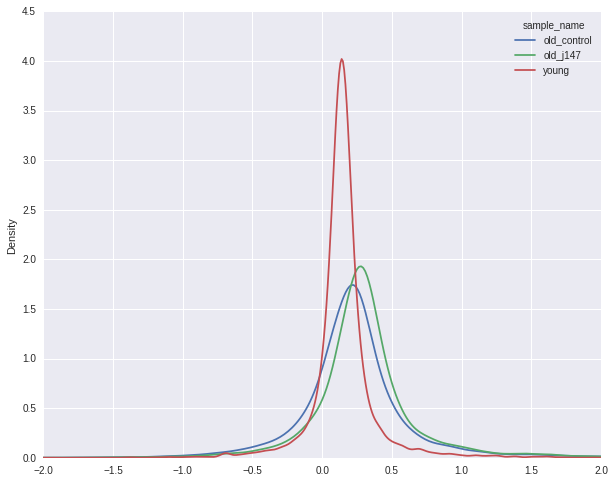

In [40]:
fig = plot_multi_density(
    res, "gene_id", "sample_name", "drift",
    rc = {"figure.figsize": (10, 8)}
)

fig.set_xlim((-2, 2))

---

## Normalize drifts to have a mean of zero

In [41]:
sample_means = res.groupby("sample_name").apply(lambda df: df["drift"].mean())
res["mean"] = res["sample_name"].map(lambda v: sample_means[v])
res["drift"] -= res["mean"]
res = res.drop("mean", axis = 1)

(-2, 2)

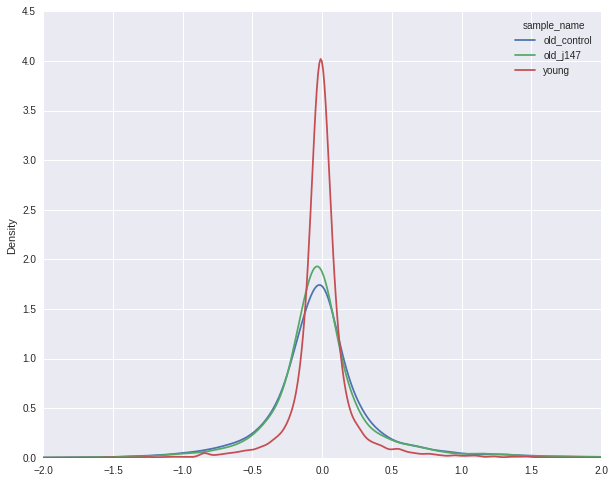

In [42]:
fig = plot_multi_density(
    res, "gene_id", "sample_name", "drift",
    rc = {"figure.figsize": (10, 8)}
)

fig.set_xlim((-2, 2))

In [43]:
res.head()

,months_old,drug_given,gene_id,gene_count,log_count,ref_log_count,ref_sample,drift,sample_name
0,3,vehicle,0610007P14Rik,342.5,5.836272,5.720312,1,-0.034888,young
1,3,vehicle,0610009B22Rik,154.0,5.036953,4.836282,1,0.049823,young
2,3,vehicle,0610009L18Rik,23.5,3.157000,2.944439,1,0.061714,young
3,3,vehicle,0610009O20Rik,551.0,6.311735,6.214608,1,-0.053721,young
4,3,vehicle,0610010F05Rik,694.0,6.542472,6.545350,1,-0.153725,young


## Save to file

In [44]:
res.to_csv("norm_avg_drift.tsv", sep = '\t', index = False)